### Facens - Pós graduação em inteligência artificial aplicada
#### Fundamentos de Programação e Estatística / 2020PGS1M1
Alunos:
- Guilherme William Sanches - 
- José Augusto Godeguezi da Costa - 203127
- Luana Ávila Matos - 203216
---

### Objetivo
- Expectativa de vida por país (ano de 2015)

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.collections import PatchCollection
from sklearn.model_selection import train_test_split as tts
from sklearn.linear_model import LinearRegression
from sklearn import metrics
import itertools
import statsmodels.api as sm
from scipy import stats
from statsmodels.formula.api import ols

In [2]:
def plot_data(plot_type, data, nrows, ncols, to_exclude, figsize):
    '''
        Faz a plotagem dos dados.

        Args:
            plot_type (str): Tipo da plotagem: b = boxplot; d = distplot.
            ncols (int): Número de linhas.
            cols (int): Número de colunas.
            to_exclude (int): Subplote a ser ignorado.
            figsize (tuple): Dimensões da figura.

    '''
    fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize)
    col = data.columns
    index = 0
    flatui = ["#9b59b6", "#3498db", "#95a5a6", "#e74c3c", "#34495e", "#2ecc71", 
              "#ff7979", "#8c7ae6", "#00a8ff", "#fbc531", "#be2edd", "#7ed6df", "#6ab04c"]
    flatui = flatui * int(np.ceil(nrows * ncols / len(flatui)))
    
    for i in range(nrows):
        for j in range(ncols):
            if index < to_exclude:
                if plot_type == 'b':
                    p = sns.color_palette([flatui[index]])
                    sns.boxplot(data[col[index]], ax=ax[i][j], orient="v", showfliers=False, palette=p)
                elif plot_type == 'd':
                    sns.distplot(data[col[index]], ax = ax[i][j])
            index += 1        
    plt.tight_layout()

In [3]:
def get_correlated_features(corrdata, threshold):
    '''
        Retorna uma série com as features correlatas, com correlação superiores a um threshold.

        Args:
            corrdata (DataFrame): DataFrame com as correlações entre as séries.
            threshold (float): Valor mínimo da correlação.

        Returns:
            (DataFrame): DataFrame com as features e o valor da correlação.
    '''
    feature = []
    values = []
    
    for i, index in enumerate(corrdata.index):
        if abs(corrdata[index]) > threshold:
            feature.append(index)
            values.append(corrdata[index])
            
    df = pd.DataFrame(data=values, index=feature, columns=['corr_value'])
    return df

In [4]:
def equation(intercept, coefficients, headers, precision=4):
    '''
        Retorna uma string com uma equação formatada.

        Args:
            intercept (float): Valor do intercepto.
            coefficients (np.arry): Array com valores dos coeficientes.
            headers (list): Lista com os labels dos coeficientes.
            precision (int): Precisão decimal dos valores (default: 4).

        Returns:
            (string): Equação.
    '''
    signal = lambda v : ' - ' if v < 0 else ''
    sabs = lambda v : str(abs(round(v, precision)))
    s = signal(intercept) + sabs(intercept)
    for c, h in zip(coefficients, headers):
        s += (' - ' if c < 0 else ' + ') + sabs(c) + '*' + h    
    return s

In [5]:
def best_combination(linreg, data, intercept_label, conf_inter=0.95):
    '''
        Retorna uma lista com os headers da melhor combinação entre os dados, 
        com base no intervalo de confiança e o menor valor da raiz quadrada 
        do erro quadrático médio (MRSE).

        Args:
            linreg (LinearRegression): Instancia do LinearRegression.
            data (DataFrame): DataFrame dos dados.
            intercept_label (str): Label do intercepto.
            conf_inter (decimal): Intervalo de confiança (default: 0.95).

        Returns:
            (list): Lista com os headers da combinação com o melhor resultado.
    '''
    X_labels = list(data.columns.values) # pega os headers das colunas
    X_labels.remove(intercept_label) # remove o label do intercepto
    best_mrse = None
    best_comb = []
    combinations = []    
    y = data[intercept_label] 
    
    # cria uma lista com todas as combinações possíveis dos coeficientes
    for i in range(len(X_labels)):
        combinations.append(list(itertools.combinations(X_labels, i+1)))
    for pair in combinations:
        for c in pair:
            c = list(c)
            X = data[c]
            
            mod = sm.OLS(y,X)
            results = mod.fit()
            
            # verifica se os p-valores e o r2 ajustado estão dentro do intervalo de confiança
            if (results.rsquared_adj > conf_inter 
                  and not results.pvalues[results.pvalues > 1 - conf_inter].any()):   
                
                # separa os dados entre treinamento e validação
                X_train, X_test, y_train, y_test = tts(X, y, random_state=1)
                linreg.fit(X=X_train, y=y_train)
                y_pred = linreg.predict(X_test)
                
                # calcula o MRSE
                mse = metrics.mean_squared_error(y_test, y_pred)
                mrse = np.sqrt(mse)
                
                if not best_mrse or best_mrse > mrse:
                    best_mrse = mrse
                    best_comb = c

    return best_comb

In [6]:
def single_result(linreg, data, intercept_label, precision=4):
    '''
        Imprime o resultado de uma regressão linear.

        Args:
            linreg (LinearRegression): Instancia do LinearRegression.
            data (DataFrame): DataFrame dos dados.
            intercept_label (str): Label do intercepto.
            precision (int): Precisão decimal dos valores (default: 4).

    '''    
    X_labels = list(data.columns.values) # pega os headers das colunas
    if intercept_label in X_labels:
        X_labels.remove(intercept_label) # remove o label do intercepto
        
    # separa os dados entre treinamento e validação
    X = data[X_labels]
    y = data[intercept_label]
    X_train, X_test, y_train, y_test = tts(X, y, random_state=1)
    linreg.fit(X=X_train, y=y_train)
    y_pred = linreg.predict(X_test)
    
    mae = round(metrics.mean_absolute_error(y_test, y_pred), precision)
    mse = round(metrics.mean_squared_error(y_test, y_pred), precision)
    mrse = round(np.sqrt(mse), precision)
    intercept = round(linreg.intercept_, precision)
    coef = [round(n, precision) for n in linreg.coef_]
    eq = equation(intercept, coef, X_labels, precision)
    
    s = 'Coefficients:'
    for i in range(len(coef)):
        s += ' {c[' + str(i) + ']};'
    
    print('Intercept: ', intercept)
    print(s.format(c=coef))
    print('MAE: ', mae)
    print('MSE: ', mse)
    print('MRSE: ', mrse)
    print('Equation: ', equation(intercept, coef, X_labels))

In [7]:
def new_values(n):
    '''
        Função criada para não ter que repetir código.
    '''
    d = {
        'intercept': 0.,
        'coef': np.array([np.zeros(n)]),
        'MAE': 0.,
        'MSE': 0.,
        'RMSE': 0.
    }
    return d

In [8]:
def train(linreg, X_train, X_test, y_train, y_test):
    '''
        Retorna o resultado de uma pedição de uma regressão linear.

        Args:
            linreg (LinearRegression): Instancia do LinearRegression.
            X_train (np.array): Array com os dados de X para treinamento.
            X_test (np.array): Array com os dados de X para teste.
            y_train (np.array): Array com os dados de y para treinamento.
            y_test (np.array): Array com os dados de y para teste.

        Returns:
            (dictionary): Dictionary com os valores do intercepto, coeficiente,
                              MAE, MSE e RMSE.
    '''
    linreg.fit(X_train, y_train)
    y_pred = linreg.predict(X_test)
    dic = { 
        'intercept': linreg.intercept_,
        'coef': linreg.coef_,
        'MAE': metrics.mean_absolute_error(y_test, y_pred),
        'MSE': metrics.mean_squared_error(y_test, y_pred),
        'RMSE': np.sqrt(metrics.mean_squared_error(y_test, y_pred)),
    }
    
    return dic 

In [9]:
def r_fold(data, r, y_label, linreg):
    '''
        Retorna o resultado de uma pedição de uma regressão linear, utilizando o método
        r-fold para separação dos dados em treinamento e teste.

        Args:
            data (DataFrame): DataFrame dos dados.
            r (int): Número de divisões do conjunto de dados.
            y_label (str): Label do intercepto.
            linreg (LinearRegression): Instancia do LinearRegression.

        Returns:
            (dictionary): Dictionary com os valores do intercepto, coeficiente,
                              MAE, MSE e RMSE.
    '''
    result = []    
    x_labels = list(data.columns.values) # pega os headers das colunas
    x_labels.remove(y_label) # remove o label do intercepto
    d = new_values(len(x_labels))
    
    # divide os dados em subconjuntos
    splited = np.array_split(data, r);
    
    # cria uma lista com todas as combinações possíveis desses dados
    possibilities = np.arange(0, r)
    combinations = list(itertools.combinations(possibilities, r-1))

    for cc in combinations:
        # separa uma parte para validação
        x = possibilities[~np.in1d(np.arange(possibilities.size),cc)][0]
        concat = pd.concat(splited[:x] + splited[x+1:])

        X_train, X_test, y_train, y_test = concat[x_labels], splited[x][x_labels], concat[y_label], splited[x][y_label]   

        result.append(train(linreg, X_train, X_test, y_train, y_test))
    
    # tira a média dos resultados
    for res in result:
        d = {k: d[k] + res[k] for k in res}
    
    d = {k: d[k] / r for k in res}
    
    return d

In [10]:
def best_combination_r_fold(linreg, data, r, intercept_label, conf_inter=0.95, verbose=0):
    '''
        Retorna uma lista com os headers da melhor combinação entre os dados, 
        com base no intervalo de confiança e o menor valor da raiz quadrada 
        do erro quadrático médio (MRSE), utilizando a técnica r-fold.

        Args:
            linreg (LinearRegression): Instancia do LinearRegression.
            data (DataFrame): DataFrame dos dados.
            r (int): Número de divisões do conjunto de dados.
            intercept_label (str): Label do intercepto.
            conf_inter (decimal): Intervalo de confiança (default: 0.95).
            verbose (int): Inidicativo se gostaria de ver detalhes do treinamento (default: 0). 

        Returns:
            (list): Lista com os headers da combinação com o melhor resultado.
    '''    
    X_labels = list(data.columns.values) # pega os headers das colunas
    X_labels.remove(intercept_label) # remove o label do intercepto
    best_mrse = None
    best_comb = []
    combinations = []    
    y = data[intercept_label]    
    
    # cria uma lista com todas as combinações possíveis dos coeficientes
    for i in range(1, len(X_labels)):
        combinations.append(list(itertools.combinations(X_labels, i)))
    for pair in combinations:
        for c in pair:
            c = list(c)
            X = data[c]
            results = sm.OLS(y,X).fit()
            
            # verifica se os p-valores e o r2 ajustado estão dentro do intervalo de confiança
            valid = results.rsquared_adj > conf_inter and not results.pvalues[results.pvalues > 1 - conf_inter].any()
            if (verbose):
                print('--------------------------------------------------------------------------')
                print('Combination: ', c)
                print('R2 Adj: ', results.rsquared_adj)
                print('p-values: ', list(results.pvalues))
                print('Null hypothesis: ', not valid)
                print()
            
            if (valid):      
                c.append(intercept_label)
                
                # treina e testa utilizando r-fold
                d = r_fold(data[c], r, intercept_label, linreg)
                
                if (verbose):
                    print('MAE: ', d['MAE'])
                    print('MSE: ', d['MSE'])
                    print('RMSE: ', d['RMSE'])
                    print()
                
                if not best_mrse or best_mrse > d['RMSE']:
                    best_mrse = d['RMSE']
                    best_comb = c
                    
    return best_comb

In [11]:
def single_result_r_fold(linreg, data, intercept_label, r, precision=4):
    '''
        Imprime o resultado de uma regressão linear, utilizando a técnica r-fold.

        Args:
            linreg (LinearRegression): Instancia do LinearRegression.
            data (DataFrame): DataFrame dos dados.
            intercept_label (str): Label do intercepto.
            r (int): Número de divisões do conjunto de dados.
            precision (int): Precisão decimal dos valores (default: 4).

    '''
    X_labels = list(data.columns.values)# pega os headers das colunas
    if intercept_label in X_labels:
        X_labels.remove(intercept_label) # remove o label do intercepto
       
    # treina e testa utilizando r-fold
    d = r_fold(data, r, intercept_label, linreg)
    
    mae = round(d['MAE'], precision)
    mse = round(d['MSE'], precision)
    mrse = round(d['RMSE'], precision)
    intercept = round(d['intercept'], precision)
    coef = [round(n, precision) for n in d['coef'][0]]
    eq = equation(intercept, coef, X_labels, precision)      
    s = 'Coefficients:'
    for i in range(len(coef)):
        s += ' {c[' + str(i) + ']};'
    
    print('Intercept: ', intercept)
    print(s.format(c=coef))
    print('MAE: ', mae)
    print('MSE: ', mse)
    print('MRSE: ', mrse)
    print('Equation: ', eq)

In [13]:
file_path = 'E:/Estudos/Pós/Classes/Estatística/Final paper/Expectativa de vida.csv' # caminho dos dados
data = pd.read_csv(file_path, index_col='pais', engine='python')
intercept_label = 'expectativa_vida_total' # qual o nome da coluna que representa o intercepto
headers = data.columns.values
data_lr = data[headers[:11]]
data_anova = pd.concat([data[intercept_label], data[headers[11:]]], axis=1, sort=False)

In [ ]:
# se quiser ver os resultados com o dataset do hbat, basta rodar essa célula ao invés da de cima, 
#    o restante permanece o mesmo
'''
file_path = '\HBAT.csv' # caminho dos dados
data = pd.read_csv(file_path,) 
data = data[['x' + str(i) for i in range(9, 20)]] # pega as colunas de x9 até x19
headers = data.columns.values
intercept_label = 'x19' # qual o nome da coluna que representa o intercepto
'''

In [14]:
data_lr.head()

,expectativa_vida_total,expectativa_anos_saudaveis,mortalidade_bruta,mortalidade_adulta,mortalidade_recem_nascidos,numero_medicos,taxa_desnutricao,saneamento_basico,agua_tratada,pib_per_capita,gasto_saude
pais,,,,,,,,,,,
Afeganistão,63.377,53.2,6.929,233,40.5,2.850,17.5,41,62,578.466353,10.105348
Albânia,78.025,67.8,7.367,92,6.1,12.164,1.2,98,91,3952.829458,5.900000
Argélia,76.090,65.3,4.715,96,15.5,18.325,6.0,87,93,4177.867517,6.978476
Angola,59.398,55.3,9.052,240,30.8,2.146,8.5,47,54,4166.979684,2.605795
Antígua e Barbuda,76.483,66.9,6.227,122,3.9,29.560,3.3,88,97,14286.093160,4.701754


In [15]:
data_anova.head()

,expectativa_vida_total,regiao,continente,mercado_financeiro
pais,,,,
Afeganistão,63.377,Ásia Central,Ásia,Insignificante
Albânia,78.025,Península das Balcãs,Europa,Emergente
Argélia,76.090,Norte da África,África,Insignificante
Angola,59.398,Sul da África,África,Desenvolvido
Antígua e Barbuda,76.483,América Central,América,Insignificante


In [16]:
data_lr.info()

<class 'pandas.core.frame.DataFrame'>
Index: 182 entries, Afeganistão to Zimbábue
Data columns (total 11 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   expectativa_vida_total      182 non-null    float64
 1   expectativa_anos_saudaveis  182 non-null    float64
 2   mortalidade_bruta           182 non-null    float64
 3   mortalidade_adulta          182 non-null    int64  
 4   mortalidade_recem_nascidos  182 non-null    float64
 5   numero_medicos              182 non-null    float64
 6   taxa_desnutricao            182 non-null    float64
 7   saneamento_basico           182 non-null    int64  
 8   agua_tratada                182 non-null    int64  
 9   pib_per_capita              182 non-null    float64
 10  gasto_saude                 182 non-null    float64
dtypes: float64(8), int64(3)
memory usage: 17.1+ KB


In [17]:
data_lr.describe()

,expectativa_vida_total,expectativa_anos_saudaveis,mortalidade_bruta,mortalidade_adulta,mortalidade_recem_nascidos,numero_medicos,taxa_desnutricao,saneamento_basico,agua_tratada,pib_per_capita,gasto_saude
count,182.000000,182.000000,182.000000,182.000000,182.000000,182.000000,182.000000,182.000000,182.000000,182.000000,182.000000
mean,71.408466,62.885165,7.803033,166.664835,13.829121,16.638381,5.220330,73.500000,86.258242,12412.463231,6.544687
std,7.893853,7.083921,2.785744,89.804224,11.299933,14.856676,5.561437,29.538953,17.050601,17473.014707,2.667432
min,50.881000,44.600000,1.131000,50.000000,0.900000,0.165000,0.100000,7.000000,39.000000,293.455236,1.914412
25%,65.878750,57.350000,5.938250,97.000000,4.200000,2.927250,1.625000,47.750000,78.000000,1715.330893,4.629290
50%,72.957000,64.950000,7.394500,148.000000,10.050000,13.669000,3.650000,88.000000,95.000000,4911.794829,6.273655
75%,76.839250,67.700000,9.475250,225.750000,22.475000,27.301000,7.075000,98.000000,99.000000,14276.848612,8.067787
max,83.793902,75.900000,15.750000,498.000000,44.900000,77.690000,39.500000,100.000000,100.000000,101376.496600,20.413414


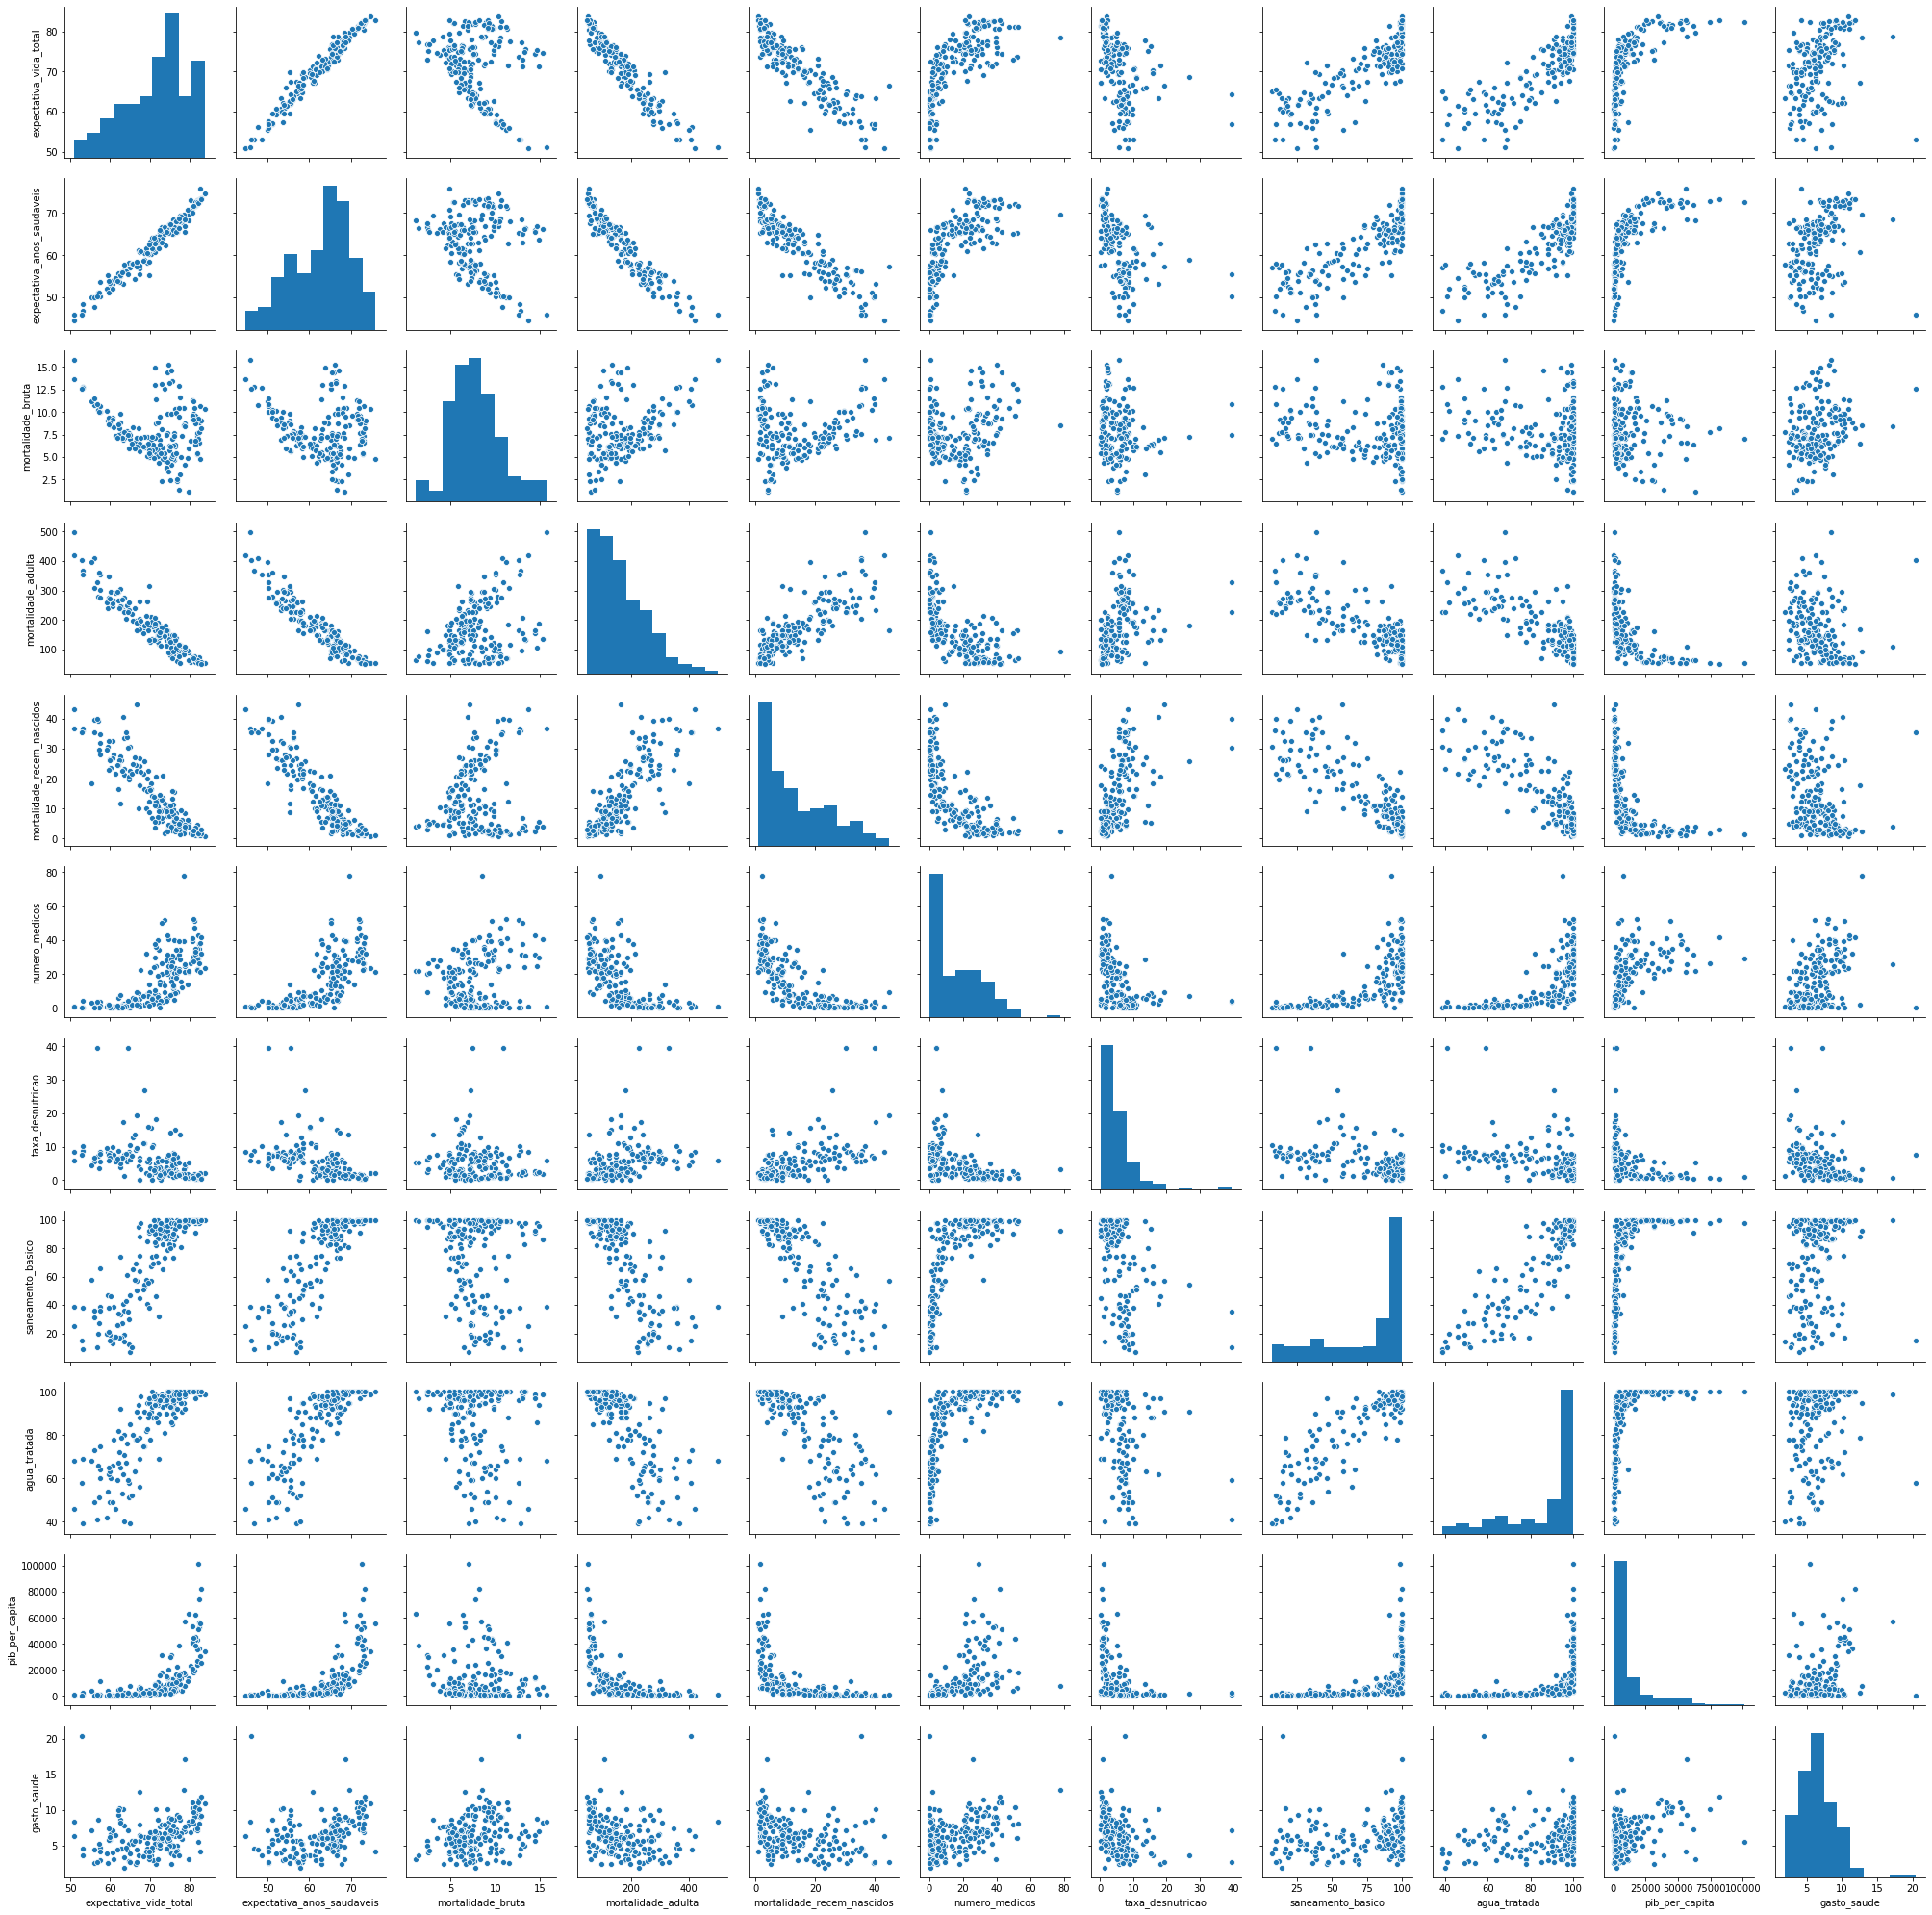

In [18]:
# plota uma comparação por pares
sns_plot = sns.pairplot(data_lr)
#  sns_plot.savefig("totalpair.png", dpi=300) # salva o resultado da plotagem

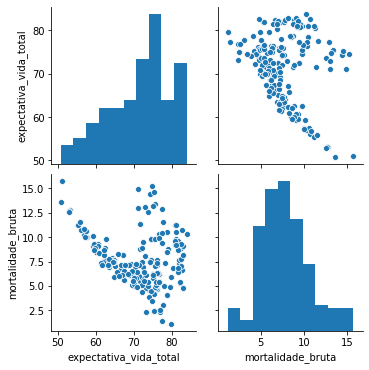

In [26]:
# 'expectativa_vida_total', 'expectativa_anos_saudaveis',
# 'mortalidade_bruta', 'mortalidade_adulta',
# 'mortalidade_recem_nascidos', 'numero_medicos', 'taxa_desnutricao',
# 'saneamento_basico', 'agua_tratada', 'pib_per_capita',
# 'gasto_saude'

# plota uma única combinação
sns_plot = sns.pairplot(data[['expectativa_vida_total', 'mortalidade_bruta']])

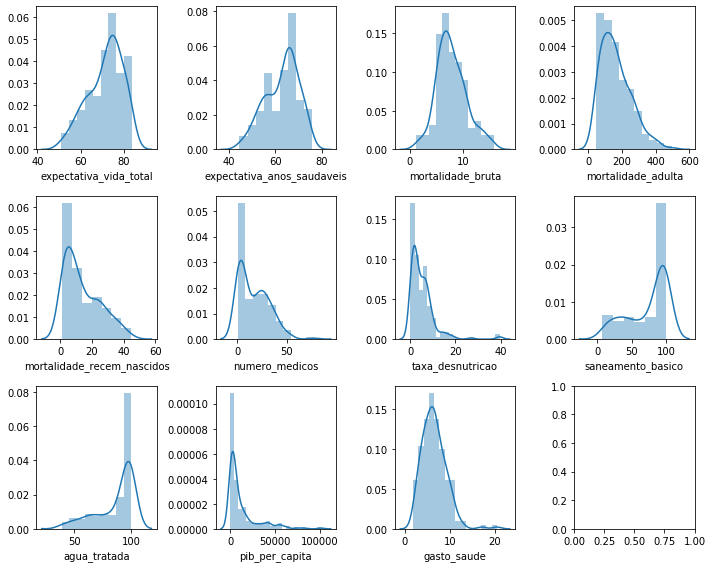

In [19]:
plot_data(plot_type='d', data=data_lr, nrows=3, ncols=4, to_exclude=11, figsize=(10,8))

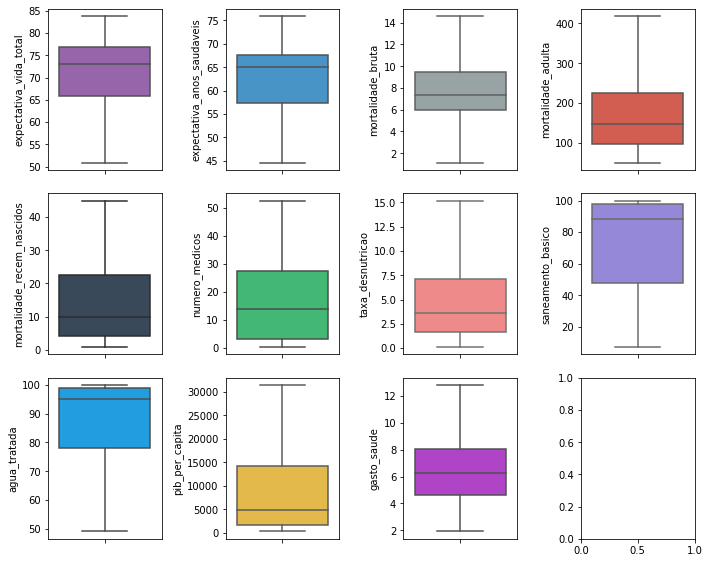

In [20]:
plot_data(plot_type='b', data=data_lr, nrows=3, ncols=4, to_exclude=11, figsize=(10,8))

In [21]:
# calcula a matriz de correlação entre os dados
corrdata = data_lr.corr()
corrdata

,expectativa_vida_total,expectativa_anos_saudaveis,mortalidade_bruta,mortalidade_adulta,mortalidade_recem_nascidos,numero_medicos,taxa_desnutricao,saneamento_basico,agua_tratada,pib_per_capita,gasto_saude
expectativa_vida_total,1.000000,0.982258,-0.253676,-0.948902,-0.901874,0.720774,-0.455005,0.849645,0.832075,0.635075,0.305857
expectativa_anos_saudaveis,0.982258,1.000000,-0.212857,-0.945999,-0.905012,0.732154,-0.495163,0.841722,0.823045,0.643951,0.314618
mortalidade_bruta,-0.253676,-0.212857,1.000000,0.325322,0.131720,0.202527,-0.068537,-0.148994,-0.175381,-0.080002,0.241604
mortalidade_adulta,-0.948902,-0.945999,0.325322,1.000000,0.817239,-0.649961,0.382601,-0.782233,-0.760221,-0.576190,-0.238739
mortalidade_recem_nascidos,-0.901874,-0.905012,0.131720,0.817239,1.000000,-0.732257,0.570983,-0.839047,-0.803428,-0.553499,-0.285517
numero_medicos,0.720774,0.732154,0.202527,-0.649961,-0.732257,1.000000,-0.435197,0.710062,0.658068,0.538699,0.405493
taxa_desnutricao,-0.455005,-0.495163,-0.068537,0.382601,0.570983,-0.435197,1.000000,-0.472355,-0.438003,-0.356139,-0.327826
saneamento_basico,0.849645,0.841722,-0.148994,-0.782233,-0.839047,0.710062,-0.472355,1.000000,0.896652,0.505538,0.239907
agua_tratada,0.832075,0.823045,-0.175381,-0.760221,-0.803428,0.658068,-0.438003,0.896652,1.000000,0.467455,0.225182
pib_per_capita,0.635075,0.643951,-0.080002,-0.576190,-0.553499,0.538699,-0.356139,0.505538,0.467455,1.000000,0.339066


In [22]:
# pega as features com correlação maior do que o threshold
threshold = 0.50
corr_value = get_correlated_features(corrdata[intercept_label], threshold)
corr_value

,corr_value
expectativa_vida_total,1.000000
expectativa_anos_saudaveis,0.982258
mortalidade_adulta,-0.948902
mortalidade_recem_nascidos,-0.901874
numero_medicos,0.720774
saneamento_basico,0.849645
agua_tratada,0.832075
pib_per_capita,0.635075


In [23]:
# pega os dados das séries com correlação maior do que o threshold
correlated_data = data_lr[corr_value.index]
correlated_data.head()

,expectativa_vida_total,expectativa_anos_saudaveis,mortalidade_adulta,mortalidade_recem_nascidos,numero_medicos,saneamento_basico,agua_tratada,pib_per_capita
pais,,,,,,,,
Afeganistão,63.377,53.2,233,40.5,2.850,41,62,578.466353
Albânia,78.025,67.8,92,6.1,12.164,98,91,3952.829458
Argélia,76.090,65.3,96,15.5,18.325,87,93,4177.867517
Angola,59.398,55.3,240,30.8,2.146,47,54,4166.979684
Antígua e Barbuda,76.483,66.9,122,3.9,29.560,88,97,14286.093160


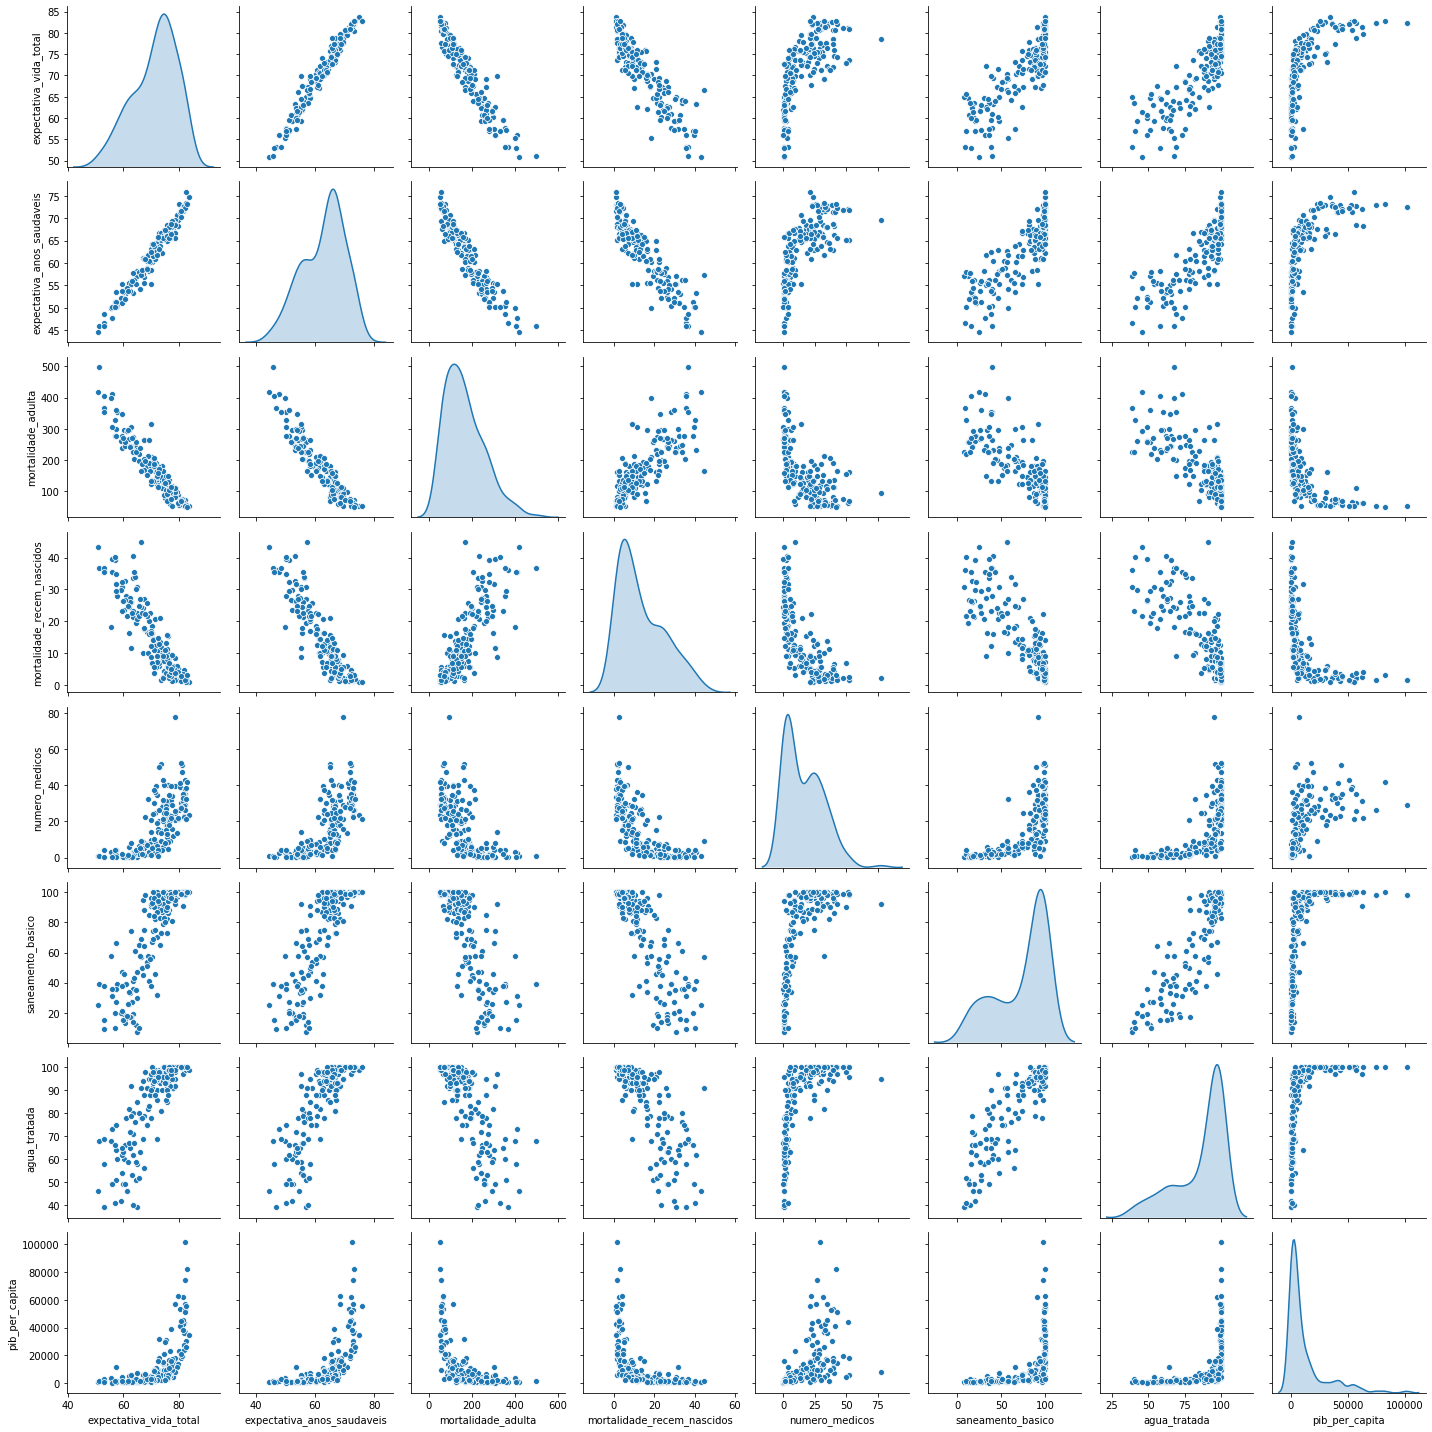

In [24]:
# plota uma comparação por pares dos novos dados
sns.pairplot(correlated_data, diag_kind='kde')
plt.tight_layout()

In [25]:
# exemplo de chamada do treinamento r-fold
precision = 4
r = data_lr[intercept_label].size # para treinamento "Leave-one-out" (demora um pouco para sair os resultados)
conf_inter = 0.95
linreg = LinearRegression()
c = best_combination_r_fold(linreg, data=correlated_data, 
                            r=r, intercept_label=intercept_label, 
                            conf_inter=conf_inter, verbose=0)
single_result_r_fold(linreg, correlated_data[c], intercept_label, r, precision=precision)

Intercept:  20.4442
Coefficients: 0.8037; -0.0178; 0.0392;
MAE:  0.9931
MSE:  1.9196
MRSE:  0.9931
Equation:  20.4442 + 0.8037*expectativa_anos_saudaveis - 0.0178*mortalidade_adulta + 0.0392*agua_tratada


In [24]:
# exemplo de chamada para treinamento 'normal'
precision = 4
conf_inter = 0.95
linreg = LinearRegression()
c = best_combination(linreg, correlated_data, intercept_label, conf_inter)
c.append(intercept_label)
single_result(linreg, correlated_data[c], intercept_label, precision)

Intercept:  19.9881
Coefficients: 0.8019; -0.0172; 0.0445;
MAE:  0.8842
MSE:  1.323
MRSE:  1.1502
Equation:  19.9881 + 0.8019*expectativa_anos_saudaveis - 0.0172*mortalidade_adulta + 0.0445*agua_tratada


---

# Descrição das séries

Abaixo temos uma breve descrição do significado de cada série encontrada nesse trabalho, juntamente com seus métodos de medida e fontes.  
Todos os dados foram colhidos entre os dias 9 e 10 de maio de 2020.

---
### 1 - País
País ao qual os dados se referem.

### 2 - Expectativa de vida total
Espectativa de vida de recém-nascidos, indicando o número de anos que viveriam, se os padrões de mortalidade vigorando no seu nascimento fossem mantidos durante toda sua vida.   
  
**Método de medida**: Descritos na fonte dos dados.  
  
**Fonte**: [DataBank - Life expectancy at birth, total (years)](https://databank.worldbank.org/reports.aspx?source=2&series=SP.DYN.LE00.IN&country=#)

### 3 - Expectativa de anos saudáveis
Espectativa de anos que um recém-nascidos viveriam de forma saudável (livre de doenças), se os padrões de mortalidade vigorando no seu nascimento fossem mantidos durante toda sua vida.  
  
**Método de medida**: Descritos na fonte dos dados.  
  
**Fonte**: [GHO - Healthy life expectancy (HALE)](https://apps.who.int/gho/data/node.main.HALE?lang=en)

### 4 - Mortalidade bruta
Taxa bruta de mortalidade, indicando o número de óbitos por mil habitantes (por ano).  
  
**Método de medida**: Número de óbitos a cada mil habitantes (por ano).  
  
**Fonte**: [DataBank - Death rate, crude (per 1,000 people)](https://databank.worldbank.org/reports.aspx?source=2&series=SP.DYN.CDRT.IN&country=#)

### 5 - Mortalidade adulta
Probabilidade de que uma pessoa de 15 anos virá a óbito antes de atingir os 60 anos.  
  
**Método de medida**: Porcentagem de óbitos a cada 10 mil habitantes.  
  
**Fonte**: [GHO - Adult mortality](https://apps.who.int/gho/data/view.main.1360)

### 6 - Mortalida de recém-nascidos
Número de recém-nascidos vivos que vieram a óbito antes de completarem 28 dias de vida.  
  
**Método de medida**: Número de óbitos a cada mil nascimentos.  
  
**Fonte**: [GHO - Newborn and child mortality](https://apps.who.int/gho/data/node.main.SDG32?lang=en)

### 7 - Número de médicos (para cada 10 mil habitantes)
Número de médicos disponíveis para cada 10 mil habitantes (sem distinção da especialização).  
  
**Método de medida**: Descritos na fonte dos dados.  
  
**Fonte**: [GHO - Medical doctors (per 10 000 population)](https://apps.who.int/gho/data/node.main.SDG3C?lang=en)

### 8 - Taxa de desnutrição (entre as idades de 5 e 19 anos)
Taxa da população entre 5 e 19 anos que sofre de desnutrição.  
  
**Método de medida**: Descritos na fonte dos dados.  
  
**Fonte**: [GHO - Thinness, crude](https://apps.who.int/gho/data/view.main.NCDCHILDBMIMINUS2Cv)

### 9 - Saneamento básico
Porcentagem da população que tem acesso a serviços de saneamento básico, que não são compartilhadas com outras famílias.  
  
**Método de medida**: Descritos na fonte dos dados.  
  
**Fonte**: [GHO - Basic and safely managed sanitation services](https://apps.who.int/gho/data/node.main.WSHSANITATION?lang=en)

### 10 - Água tratada
Porcentagem da população que tem acesso a água tratada.    
  
**Método de medida**: Descritos na fonte dos dados.  
  
**Fonte**: [GHO - Basic and safely managed drinking water services](https://apps.who.int/gho/data/node.main.WSHWATER?lang=en)

### 11 - PIB per capita (em dólares)
PIB per capita do país calculado em dólares americanos.  
  
**Método de medida**: Descritos na fonte dos dados.  
  
**Fonte**: [DataBank - GDP per capita](https://databank.worldbank.org/reports.aspx?source=2&series=NY.GDP.PCAP.CD&country=#)

### 12 - Gasto com saúde (% do PIB)
Porcentagem do PIB gastos com saúde pública calculado em dólares americanos.  
  
**Método de medida**: Descritos na fonte dos dados.  
  
**Fonte**: [DataBank - Current health expenditure (% of GDP)](https://databank.worldbank.org/home.aspx)

### 13 - Região
Consiste nas divisões internas de cada continente em que o país se encontra, com exceção da oceania.  
  
**Fontes**: 
- [Algosobre - África, a Diversidade num Continente](https://www.algosobre.com.br/geografia/africa-a-diversidade-num-continente.html)  
- [Algosobre - Américas, Cinco Divisões em Um Continente](https://www.algosobre.com.br/geografia/americas-cinco-divisoes-em-um-continente.html)  
- [Algosobre - Ásia: suas divisões internas](https://www.algosobre.com.br/geografia/asia-suas-divisoes-internas.html)  
- [Algosobre - Europa: Divisão Regional](https://www.algosobre.com.br/geografia/europa-divisao-regional.html)  

### 14 - Continente
Continente em que o país se encontra.  

### 15 - Mercado Financeiro
.  
  
**Método de medida**: .  
  
**Fonte**: []()